# 📑 Problem Definition
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

# 💾 Data Dictionary
* `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for *Port* or `S` for *Starboard*.
* `Destination` - The planet the passenger will be debarking to.
* `Age` - The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# 🔍 Exploratory Data Analysis (EDA)

## Looking for NAs
If a feature has >=30% nulls, we disregard it.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
pd.Series(data=[train[col].isna().sum() / train[col].size * 100 for col in train.columns], index=[col for col in train.columns], name="Percentage Missing").sort_values(ascending=False)

CryoSleep       2.496261
ShoppingMall    2.392730
VIP             2.335212
HomePlanet      2.312205
Name            2.300702
Cabin           2.289198
VRDeck          2.162660
FoodCourt       2.105142
Spa             2.105142
Destination     2.093639
RoomService     2.082135
Age             2.059128
PassengerId     0.000000
Transported     0.000000
Name: Percentage Missing, dtype: float64

With ```rangeIndex: 8693```, it would seem that all our features are filled to a satisfactory level. 

## Checking Duplicates

In [5]:
duplicates = pd.DataFrame(train.loc[train.duplicated(subset=["Name"])].query("not Name.isnull()"))
print("Duplicate samples:")
display(duplicates[:5])
print(f"Total amount of duplicate names: {len(duplicates.index)}")

Duplicate samples:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
956,1018_01,Earth,True,G/150/P,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Elaney Webstephrey,True
2700,2892_03,Earth,True,G/469/P,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,Sharie Gallenry,True
2852,3081_01,Europa,False,C/118/S,55 Cancri e,50.0,False,0.0,1547.0,0.0,1784.0,1.0,Gollux Reedall,True
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True
3291,3535_02,Mars,True,F/668/S,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Grake Porki,True


Total amount of duplicate names: 20


In [6]:
display(train.query('Name == "Elaney Webstephrey"'))
display(train.query('Name == "Sharie Gallenry"'))
display(train.query('Name == "Gollux Reedall"'))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
156,0179_01,Earth,False,G/26/P,TRAPPIST-1e,19.0,False,1.0,219.0,673.0,2.0,11.0,Elaney Webstephrey,True
956,1018_01,Earth,True,G/150/P,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Elaney Webstephrey,True


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1812,1935_01,Earth,True,G/307/S,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Sharie Gallenry,False
2700,2892_03,Earth,True,G/469/P,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,Sharie Gallenry,True


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
827,0881_01,Europa,False,D/32/S,TRAPPIST-1e,41.0,False,3103.0,3.0,0.0,31.0,26.0,Gollux Reedall,False
2852,3081_01,Europa,False,C/118/S,55 Cancri e,50.0,False,0.0,1547.0,0.0,1784.0,1.0,Gollux Reedall,True


As the names are not a feature which our model will consider whilst learning, and the data for these duplicates differs, we'll leave them in our model. Odds are they just duplicated by chance while the model was being generated. 

## Initial Thoughts
* ```PassengerID```: Doesn't seem very useful to training the model as each PassengerID is too unique. Could potentially create binary features ```inGroup``` to see if the groups display any significant correlation with ```Transported```.

* ```HomePlanet```: Doesn't seem like it would have much of a correlation. Will need to be transposed to a set of binary features to check.

* ```CryoSleep```: Being in cryosleep means that you're basically confined to your cabin. The model will likely pick up on a correlation between the ```CyroSleep```: feature and the ```Cabin``` feature. Some areas of the ship may have had a higher transportation percentage than others.

* ```Cabin```: Will need to be split into 3 features, ```deck```, ```num```, and ```side```. 

* ```Destionation```: Very unlikely to see a correlation between ```Destionation``` and ```Transported```. 

* ```Age```: Being younger means being stronger which generally aids survivability. It is unclear if this would help with this gravitational anomaly, but we don't discard it until we've tested it. 

* ```VIP```: Much like ```CryoSleep``` I only suspect this to have a correlation due to the likelihood of a correlation between ```VIP``` and ```Cabin```. For instance, VIPs may have been located on a special deck that happened to be disproportionatly affected by the gravitational anomaly (be it positively or negatively).

* ```RoomService```, ```FoodCourt```, ```ShoppingMall```, ```Spa```, ```VRDeck```: Once again, these features are indicative of where the passenger has spent their most time, and hence where they are most likely to be located at the time of the anomaly. It could also give us an idea of where their cabin is likely to be located, and ```RoomService``` specifically gives us a good idea of how much time a passenger has spent in their room, increasing the odds that they were there during the anomaly. These all have a high likelihood of being correlated with ```Cabin```. 

* ```Name```: I don't see any potential relevance here:(

## Splitting the ```Cabin``` Feature

In [7]:
train.Cabin

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [8]:
train[["CabinDeck", "CabinNum", "CabinSide"]] = train.Cabin.apply(lambda cabin: pd.Series(cabin.split("/") if not pd.isnull(cabin) else [float("NaN"), float("NaN"), float("NaN")]))
test[["CabinDeck", "CabinNum", "CabinSide"]] = test.Cabin.apply(lambda cabin: pd.Series(cabin.split("/") if not pd.isnull(cabin) else [float("NaN"), float("NaN"), float("NaN")]))

## Univariate Analysis
Let's separate numerical and categorical features so we can visualize them separately. 

In [9]:
# Seperating categorical feature names and numerical feature names
categorical_features = [col for col in train.columns if train[col].dtype == "object"]

# We can remove the following three features from the list since we won't be dealing with those
categorical_features.remove("Name")
categorical_features.remove("Cabin")
categorical_features.remove("CabinNum")

numerical_features = [col for col in train.columns if train[col].dtype == "int64" or train[col].dtype == "float64"]

print(categorical_features)
print(numerical_features)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [10]:
# Seperating the data
train_cat = train[categorical_features]
train_num = train[numerical_features]

### Numerical Data

We'll be plotting the numerical data with Kernel Density Estimation (KDE).

In [11]:
train_num.columns.to_list()

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

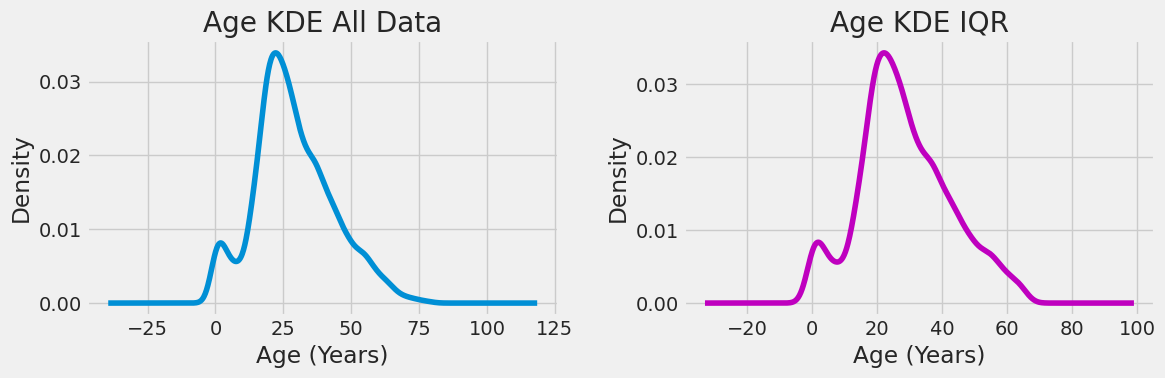

X-axis range for Age Distribution All Data: (-47.4, 126.4)
X-axis range for Age Distribution IQR: (-39.6, 105.6)


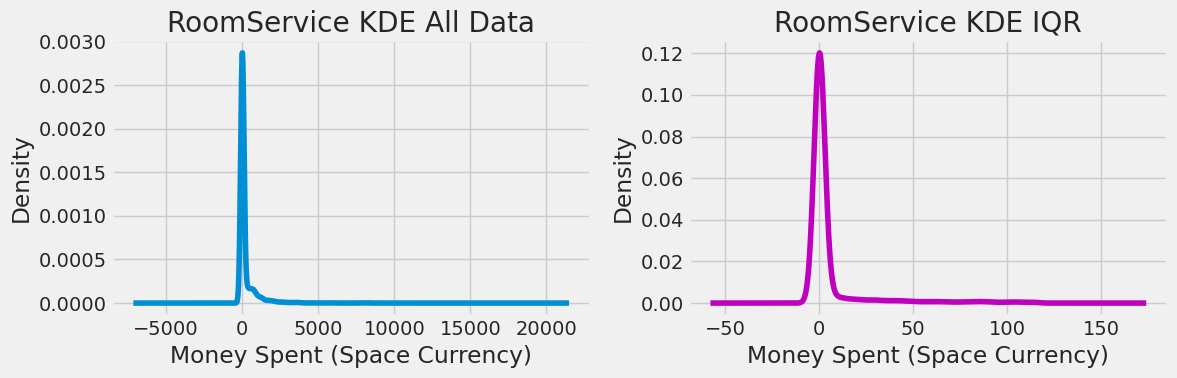

X-axis range for RoomService Distribution All Data: (-8596.2, 22923.2)
X-axis range for RoomService Distribution IQR: (-69.6, 185.6)


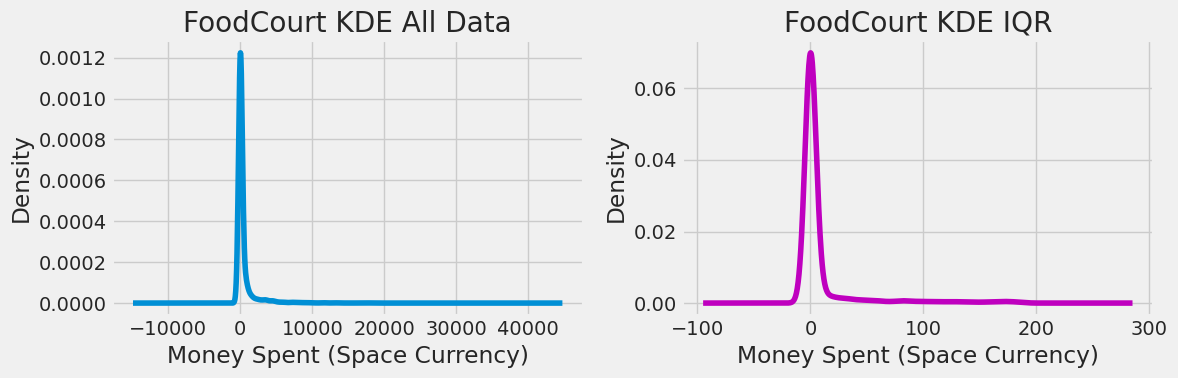

X-axis range for FoodCourt Distribution All Data: (-17887.8, 47700.8)
X-axis range for FoodCourt Distribution IQR: (-114.0, 304.0)


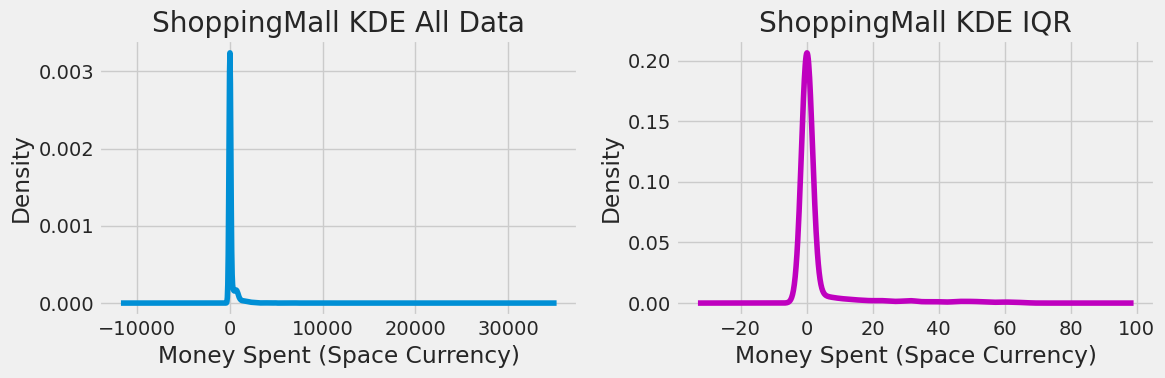

X-axis range for ShoppingMall Distribution All Data: (-14095.2, 37587.2)
X-axis range for ShoppingMall Distribution IQR: (-39.6, 105.6)


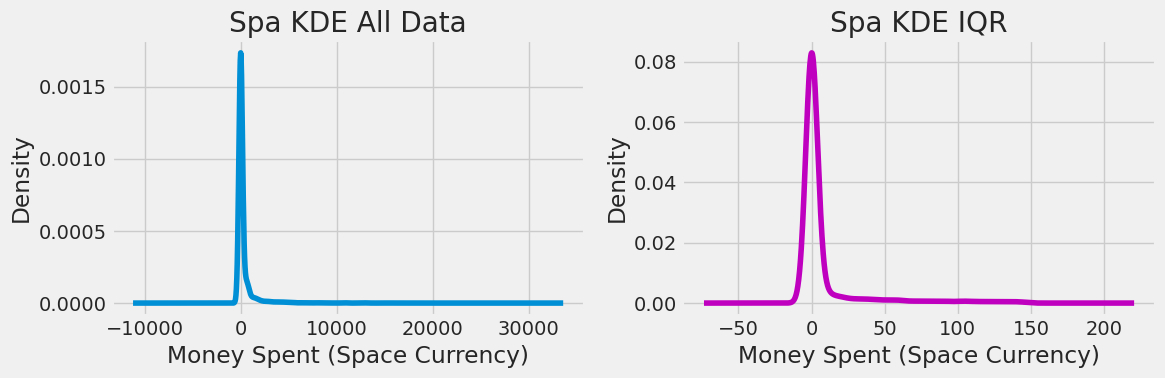

X-axis range for Spa Distribution All Data: (-13444.8, 35852.8)
X-axis range for Spa Distribution IQR: (-88.2, 235.2)


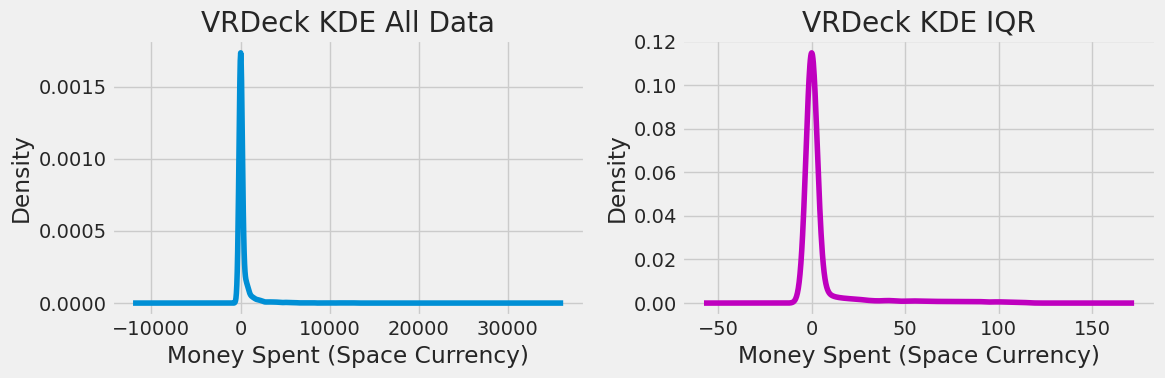

X-axis range for VRDeck Distribution All Data: (-14479.8, 38612.8)
X-axis range for VRDeck Distribution IQR: (-69.0, 184.0)


In [12]:
for i in train_num.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    train_num[i].plot(kind="kde", title=f"{i} KDE All Data", ax=ax1, )
    if i == "Age":
        ax1.set_xlabel("Age (Years)")
    else:
        ax1.set_xlabel("Money Spent (Space Currency)")

    Q1 = train_num[i].quantile(0.25)
    Q3 = train_num[i].quantile(0.75)
    IQR = Q3 - Q1

    train_num.query(f'(@Q1 - 1.5 * @IQR) <= {i} <= (@Q3 + 1.5 * @IQR)')[i] \
        .plot(kind="kde", color="m", title=f"{i} KDE IQR", ax=ax2)
    if i == "Age":
        ax2.set_xlabel("Age (Years)")
    else:
        ax2.set_xlabel("Money Spent (Space Currency)")

    plt.tight_layout()
    plt.show()
    
    # Get X-axis ranges
    range_ax1 = ax1.get_xlim()
    range_ax2 = ax2.get_xlim()

    # Print X-axis ranges
    print(f"X-axis range for {i} Distribution All Data: {range_ax1}")
    print(f"X-axis range for {i} Distribution IQR: {range_ax2}")

* **Agre Distribution:** As the distribution is already somewhat normalized, there was no major change between the "all data" distribtuion and the IQR distribution. We'll leave this this data as is without doing any transformations.

* **Rest of the Distributions:** This distribution is spiked highly at 0, presenting what looks like an incredibly rapid exponential decay. No transformation is needed when using decision or boost tree based models like XGBoost or CatBoost as they do not prefer Gaussian or standard probability distributions.

### Categorical Data
We're just going to do barplots for these.

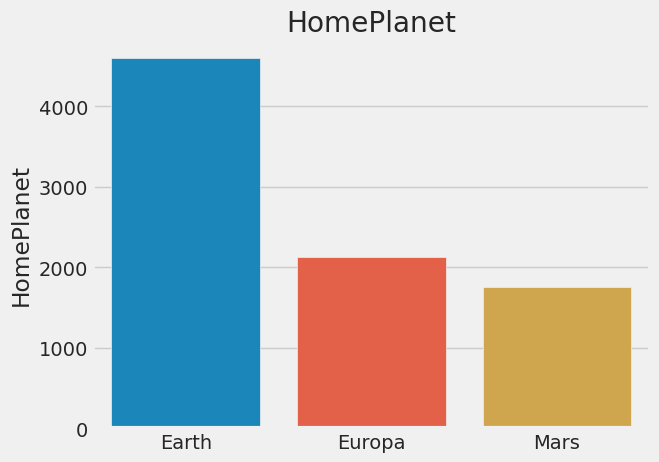

     x  height
0 -0.4  4602.0
1  0.6  2131.0
2  1.6  1759.0


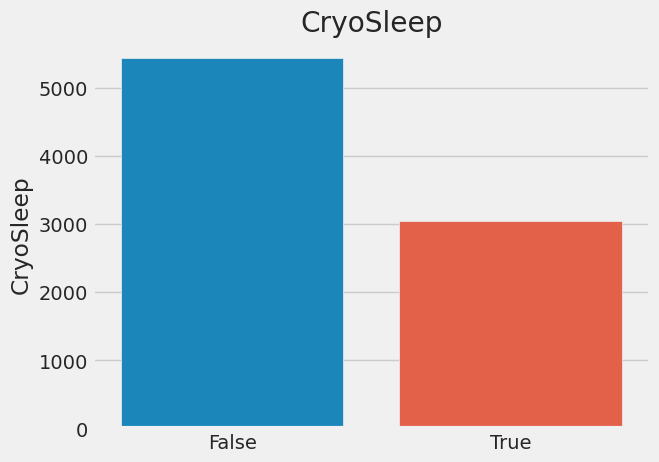

     x  height
0 -0.4  5439.0
1  0.6  3037.0


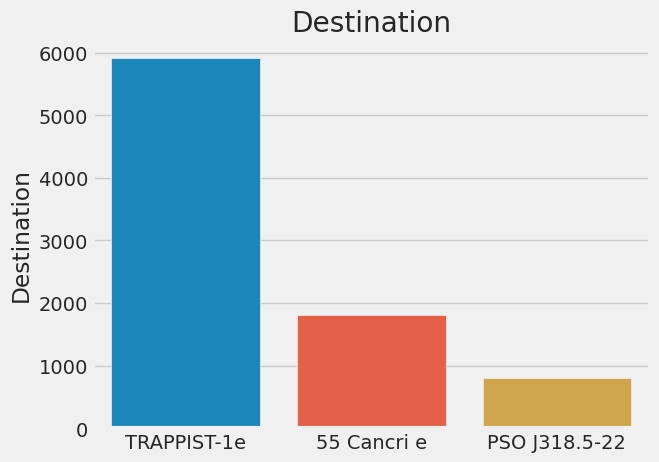

     x  height
0 -0.4  5915.0
1  0.6  1800.0
2  1.6   796.0


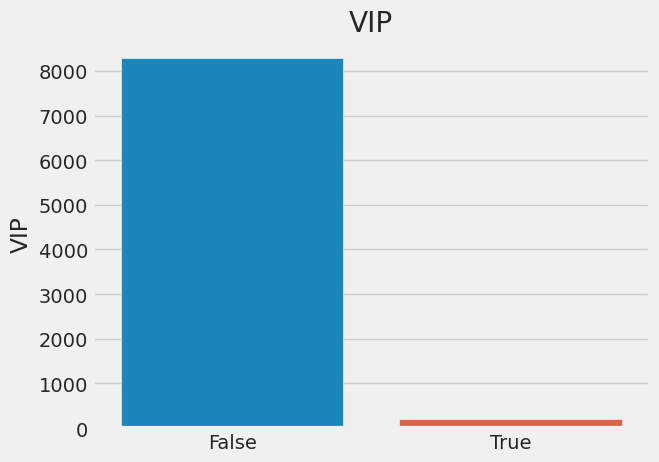

     x  height
0 -0.4  8291.0
1  0.6   199.0


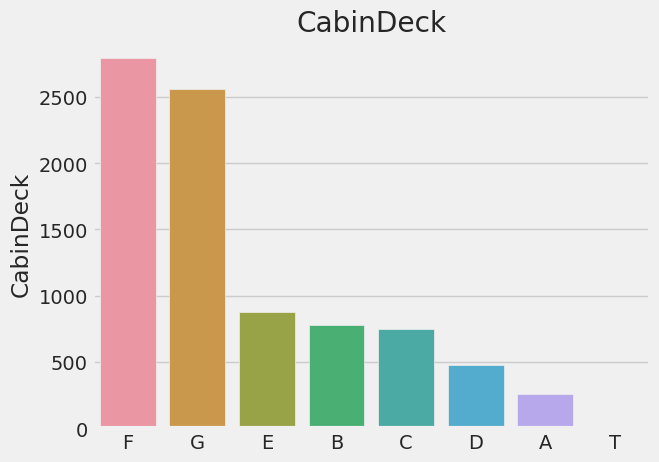

     x  height
0 -0.4  2794.0
1  0.6  2559.0
2  1.6   876.0
3  2.6   779.0
4  3.6   747.0
5  4.6   478.0
6  5.6   256.0
7  6.6     5.0


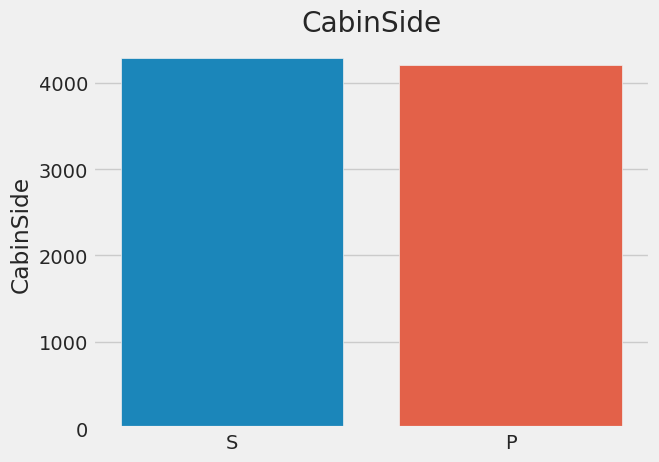

     x  height
0 -0.4  4288.0
1  0.6  4206.0


In [13]:
for i in train_cat.columns:
    if i == "PassengerId":
        continue
    
    plt.figure()
    barplot = sns.barplot(x=train_cat[i].value_counts().index, y=train_cat[i].value_counts())
    barplot.set_title(i)
    plt.show()
    
    data = []
    for container in barplot.containers:
        for bar in container:
            data.append([bar.get_x(), bar.get_height()])

    columns = ["x", "height"]
    df = pd.DataFrame(data, columns=columns)
    
    print(df)

It is clear that these features are quite imbalanced, the only balanced feature being ```CabinSide```. Resampling techniques might aid us in coping with these imbalances, but for the time being we won't do anything about them.

## Multivariate Analysis

### Numerical Data
We'll be using 3 different plot types here:
* Heatmap Correlation
* Pairplot 
* Pivot Table

#### Heatmap Correlation

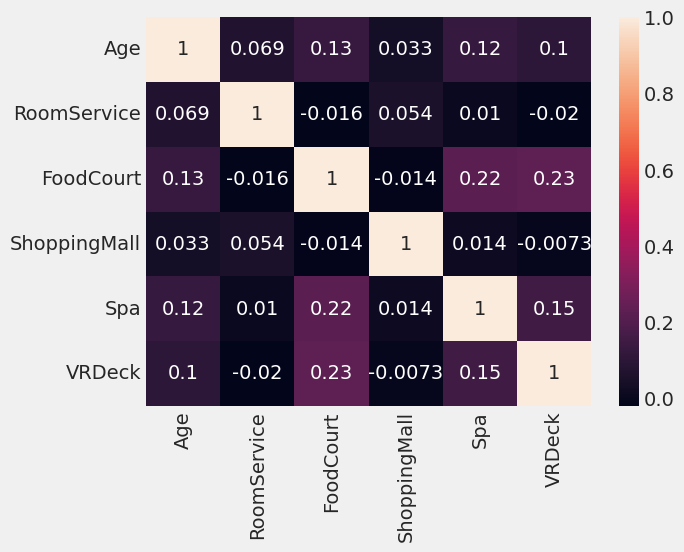

In [14]:
sns.heatmap(train_num.corr(), annot=True)
plt.show()

No noteworthy correlations here. 

#### Pairplot
Simpler than doing all the individual scatterplots since all the combinations will be present.

In [15]:
train_num_with_target = pd.concat([train_num, train.Transported.astype(int)], axis=1)
train_num_with_target

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0


['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


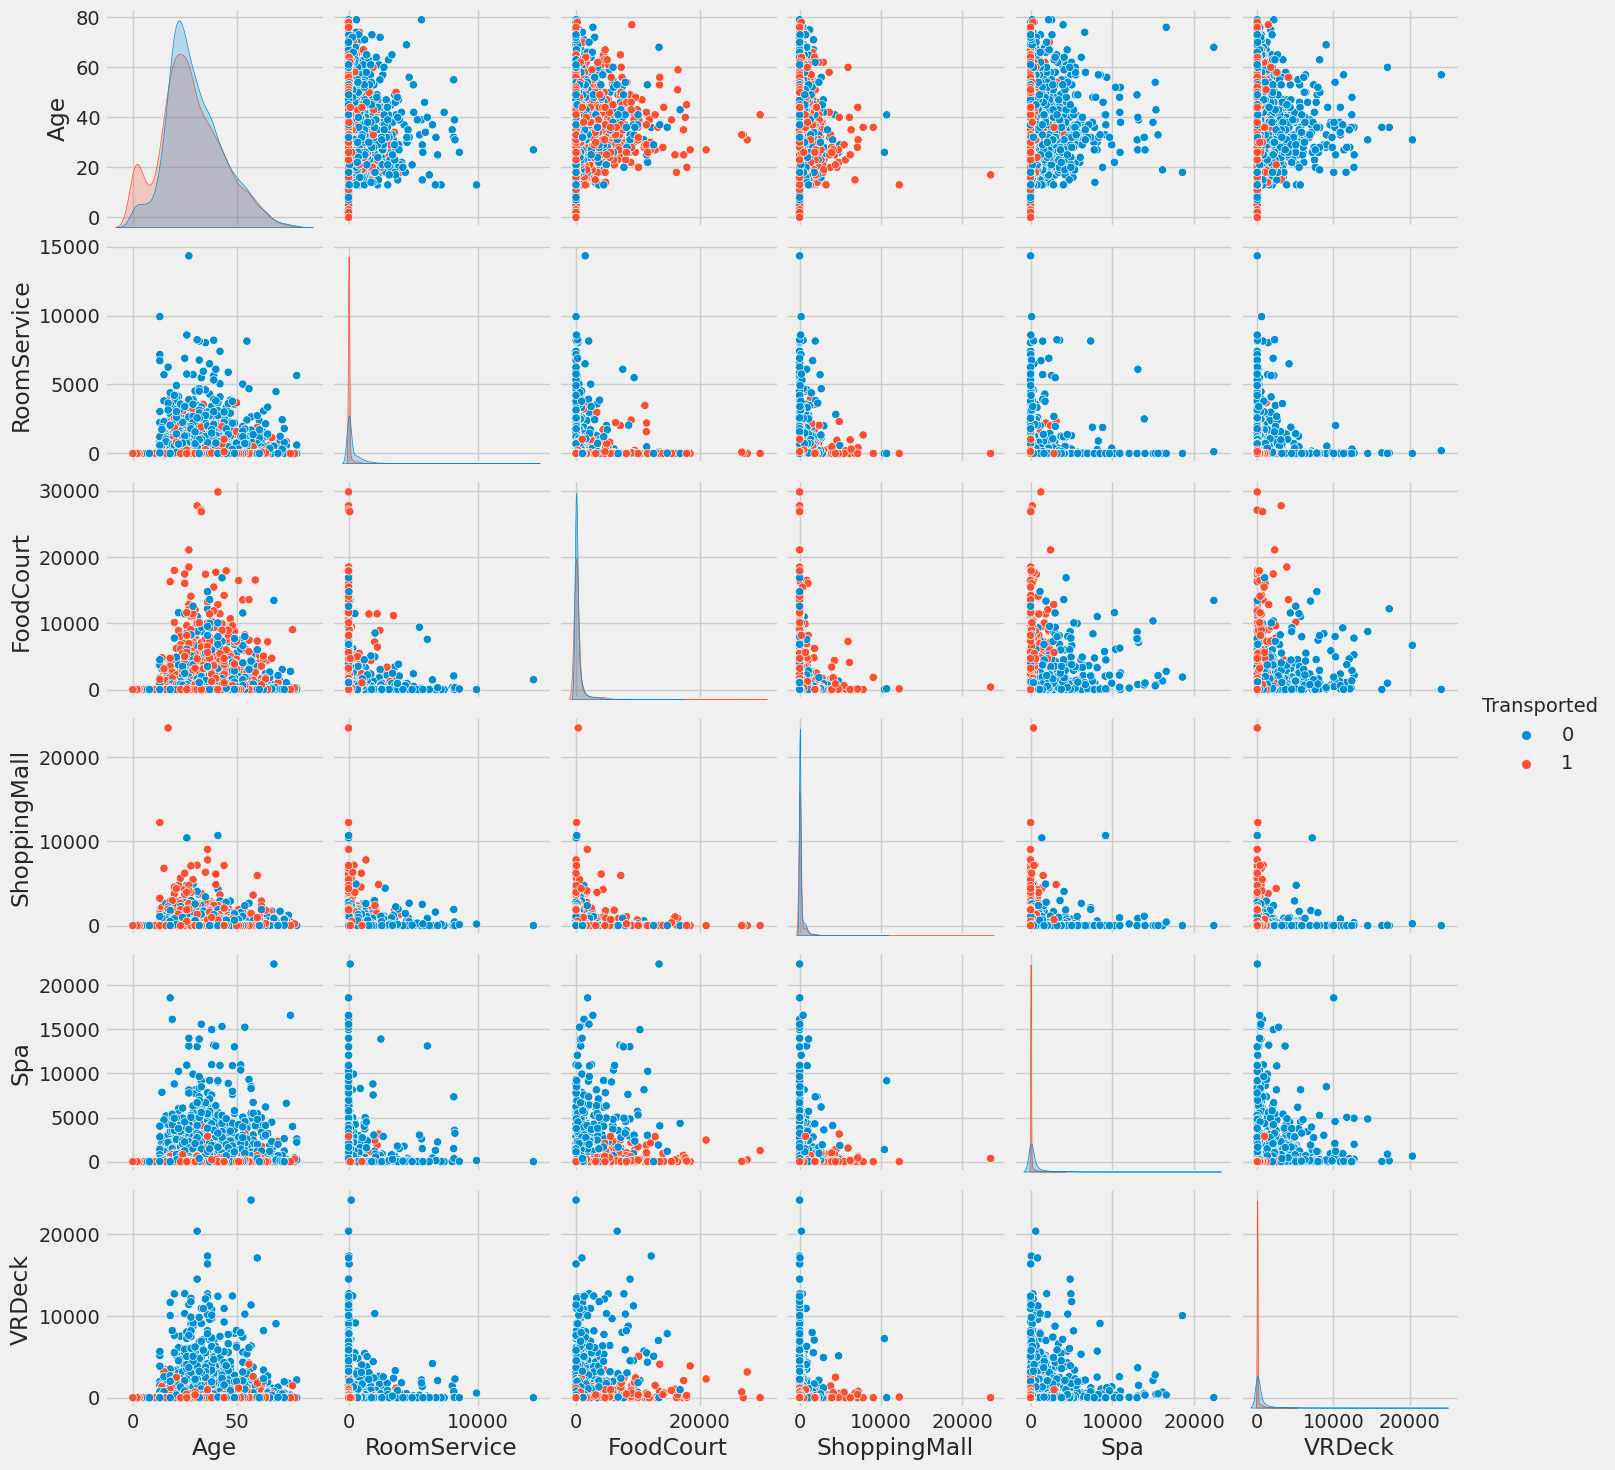

In [16]:
print(numerical_features)

sns.pairplot(train_num_with_target, vars=numerical_features, hue="Transported")
plt.show()

We notice from the distributions (diagonal) that ```RoomService```,```Spa```, and ```VRDeck``` have tall orange (transported) spikes while ```FoodCourt``` and ```ShoppingMall``` have taller blue (not transported) spike. We can also note that these taller orange spikes are much more dsitributed from the blue spikes on their distributions than with the taller bluespikes are with the orange spikes. This suggests that there is a significant positive correlation between the amount spent on ```RoomService```, the ```Spa```, and the ```VRDeck``` and the chance of ```Transported``` == ```True```. 

Furthermore, in the (```Spa```, ```ShoppingMall```), (```Spa```, ```FoodCourt```), (```VRDeck```, ```ShoppingMall```), and (```VRDeck```, ```FoodCourt```) pairplots (**X-Axis**, **Y-Axis**) there seems to be a clear line that can be drawn to separate ```Transported``` and not. This likely means that the anomaly appeared closer to the areas of the ```ShoppingMall``` and ```FoodCourt``` than it was to the ```Spa``` and ```VRDeck```. 

#### Pivot Table
Let's examine the rates of transportation of different areas fo the ship by looking at the money spent:

In [17]:
pd.pivot_table(train, index="Transported", values=numerical_features)

,Age,FoodCourt,RoomService,ShoppingMall,Spa,VRDeck
Transported,,,,,,
False,29.922858,382.615930,389.266066,167.566217,564.382666,543.629822
True,27.748834,532.691984,63.098021,179.829972,61.675531,69.148131


It would appear that the ratios of money spent on ```FoodCourt```, ```RoomService```, ```Spa```, and ```VRDeck``` are indeed relevant, as we suspected based on the pairplot. ```FoodCourt``` spending showed a positive correlation with being transported, and the other 3 showed negative correlations. 

#### Categorical Data

In [18]:
for i in train_cat.columns:
    if i == "PassengerId":
        continue
    display(pd.pivot_table(train, index = 'Transported', columns = i, values = "PassengerId", aggfunc ='count'))

HomePlanet,Earth,Europa,Mars
Transported,,,
False,2651,727,839
True,1951,1404,920


CryoSleep,False,True
Transported,,
False,3650,554
True,1789,2483


Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Transported,,,
False,702,395,3128
True,1098,401,2787


VIP,False,True
Transported,,
False,4093,123
True,4198,76


CabinDeck,A,B,C,D,E,F,G,T
Transported,,,,,,,,
False,129,207,239,271,563,1565,1238,4
True,127,572,508,207,313,1229,1321,1


CabinSide,P,S
Transported,,
False,2308,1908
True,1898,2380


* The ```CryoSleep``` feature seems significant, and as mentioned previously, being in cryosleep would suggest that you spend all your time in your cabin. An ```InCabin``` feature is certainly worth looking into. 
* In the ```CabinDeck``` feature, we see several decks which have disproporitonatly more transported individuals than not. 

## Feature Engineering
First we'll clear the dataset to get it ready for training the model with the following:
* Imputation
* Categorical Encoding

First, let's split the training data into features and target variables.

In [19]:
X = train.drop(["Transported"], axis=1).copy()
y = train.Transported.copy()

We'll also pop off ```PassengerID``` as we'll need it for making our submission.

In [20]:
test_IDs = test["PassengerId"]

X = X.drop("PassengerId", axis=1)
test = test.drop("PassengerId", axis=1)

categorical_features.remove("PassengerId")

### Imputation
Imputation is a technique for handling missing data. If greater than 80% of our samples, it would be wise to drop it entirely. However, in our case we were only missing 2 to 2.5% of values.

#### Imputing Numerical Data

In [21]:
for i in numerical_features:
    X[i] = X[i].fillna(X[i].median())
    # Using the median of the training set to impute the test set to avoid leakage
    test[i] = test[i].fillna(X[i].median())

Now we check to make sure there aren't still any missing values.

In [22]:
display(X[numerical_features].isnull().sum())
print()
display(test[numerical_features].isnull().sum())

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

#### Imputing Categorical Data

In [23]:
for i in categorical_features:
    X[i] = X[i].fillna(X[i].mode().iloc[0]) 
    # Using the mode of the training set to impute the test set to avoid leakage
    test[i] = test[i].fillna(X[i].mode().iloc[0]) 

Once again, check to make sure there aren't any remaining missing values.

In [24]:
display(X[categorical_features].isnull().sum())
print()
display(test[categorical_features].isnull().sum())

HomePlanet     0
CryoSleep      0
Destination    0
VIP            0
CabinDeck      0
CabinSide      0
dtype: int64

HomePlanet     0
CryoSleep      0
Destination    0
VIP            0
CabinDeck      0
CabinSide      0
dtype: int64

### Categorical Encoding
Categorical encoding is the process of converting categorical data to numerical values for training models. 

First off, let's check the heads of our training dataset and our test dataset.

In [25]:
display(X.head(5))
display(test.head(5))

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNum,CabinSide
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNum,CabinSide
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S


Before categorical encoding, let's remove the ```Name``` and ```CabinNum``` columns from the dataframes, since they have way too many unique values or provide way to little information for the model.

In [26]:
print(numerical_features + categorical_features)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']


In [27]:
X = X[numerical_features + categorical_features]
test = test[numerical_features + categorical_features]

Now, let's have a look at the different categorical features and how many unique values they each have (if using one-hot encoding, they should preferably have less than 15 unique values):

In [28]:
for i in categorical_features:
    print(f"Feature name: {i}. \nNo. of unique values: {X[i].nunique()} ({X[i].unique()})\n\n")

Feature name: HomePlanet. 
No. of unique values: 3 (['Europa' 'Earth' 'Mars'])


Feature name: CryoSleep. 
No. of unique values: 2 ([False  True])


Feature name: Destination. 
No. of unique values: 3 (['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e'])


Feature name: VIP. 
No. of unique values: 2 ([False  True])


Feature name: CabinDeck. 
No. of unique values: 8 (['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T'])


Feature name: CabinSide. 
No. of unique values: 2 (['P' 'S'])




All the features are well within the threshold, so we can use one-hot encoding for all of them. However, we'll use ordinal encoding for ```CabinDeck``` as it will group related values. 

Before we start encoding let's take a quick look at the datattypes again:

In [29]:
X.dtypes

Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
HomePlanet       object
CryoSleep          bool
Destination      object
VIP                bool
CabinDeck        object
CabinSide        object
dtype: object

```CryoSleep``` and ```VIP``` are of type bool, not object. We can turn those columns into 1s and 0s as so:

In [30]:
X[["CryoSleep", "VIP"]] = X[["CryoSleep", "VIP"]].astype(int)
test[["CryoSleep", "VIP"]] = test[["CryoSleep", "VIP"]].astype(int)

In [31]:
display(X.head(5))
display(test.head(5))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,0,TRAPPIST-1e,0,B,P
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,0,TRAPPIST-1e,0,F,S
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,0,TRAPPIST-1e,1,A,S
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,0,TRAPPIST-1e,0,A,S
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,0,TRAPPIST-1e,0,F,S


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,27.0,0.0,0.0,0.0,0.0,0.0,Earth,1,TRAPPIST-1e,0,G,S
1,19.0,0.0,9.0,0.0,2823.0,0.0,Earth,0,TRAPPIST-1e,0,F,S
2,31.0,0.0,0.0,0.0,0.0,0.0,Europa,1,55 Cancri e,0,C,S
3,38.0,0.0,6652.0,0.0,181.0,585.0,Europa,0,TRAPPIST-1e,0,C,S
4,20.0,10.0,0.0,635.0,0.0,0.0,Earth,0,TRAPPIST-1e,0,F,S


In [32]:
X.dtypes

Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
HomePlanet       object
CryoSleep         int64
Destination      object
VIP               int64
CabinDeck        object
CabinSide        object
dtype: object

Now to separate ```CabinDeck``` from the other categorical features:

In [33]:
ordinal_column_names = ["CabinDeck"]
one_hot_column_names = ["HomePlanet", "Destination", "CabinSide"]

#### Ordinal Encoding

We'll just use a mapping dictionary so we can ordinal encode using just Pandas.

In [34]:
deck_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
X[ordinal_column_names] = X[ordinal_column_names].replace(deck_mapping)
test[ordinal_column_names] = test[ordinal_column_names].replace(deck_mapping)
display(X.head(5))
display(test.head(5))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,0,TRAPPIST-1e,0,2,P
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,0,TRAPPIST-1e,0,6,S
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,0,TRAPPIST-1e,1,1,S
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,0,TRAPPIST-1e,0,1,S
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,0,TRAPPIST-1e,0,6,S


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,27.0,0.0,0.0,0.0,0.0,0.0,Earth,1,TRAPPIST-1e,0,7,S
1,19.0,0.0,9.0,0.0,2823.0,0.0,Earth,0,TRAPPIST-1e,0,6,S
2,31.0,0.0,0.0,0.0,0.0,0.0,Europa,1,55 Cancri e,0,3,S
3,38.0,0.0,6652.0,0.0,181.0,585.0,Europa,0,TRAPPIST-1e,0,3,S
4,20.0,10.0,0.0,635.0,0.0,0.0,Earth,0,TRAPPIST-1e,0,6,S


As T is so small, I'm not really worried about it hampering the model. 

#### Categorical Encoding


In [35]:
X = pd.get_dummies(X).copy()
test = pd.get_dummies(test).copy()

In [36]:
display(X.dtypes)
print()
display(test.dtypes)

Age                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
CryoSleep                      int64
VIP                            int64
CabinDeck                      int64
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
CabinSide_P                    uint8
CabinSide_S                    uint8
dtype: object

Age                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
CryoSleep                      int64
VIP                            int64
CabinDeck                      int64
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
CabinSide_P                    uint8
CabinSide_S                    uint8
dtype: object

In [37]:
display(X)
display(test)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,VIP,CabinDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinSide_P,CabinSide_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,0,2,0,1,0,0,0,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,0,6,1,0,0,0,0,1,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,1,0,1,0,0,0,1,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,1,0,0,0,1,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,0,0,6,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,1,0,1,0,1,0,0,1,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,1,0,7,1,0,0,0,1,0,0,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,0,0,7,1,0,0,0,0,1,0,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0,0,5,0,1,0,1,0,0,0,1


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,VIP,CabinDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinSide_P,CabinSide_S
0,27.0,0.0,0.0,0.0,0.0,0.0,1,0,7,1,0,0,0,0,1,0,1
1,19.0,0.0,9.0,0.0,2823.0,0.0,0,0,6,1,0,0,0,0,1,0,1
2,31.0,0.0,0.0,0.0,0.0,0.0,1,0,3,0,1,0,1,0,0,0,1
3,38.0,0.0,6652.0,0.0,181.0,585.0,0,0,3,0,1,0,0,0,1,0,1
4,20.0,10.0,0.0,635.0,0.0,0.0,0,0,6,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.0,0.0,0.0,0.0,0.0,0.0,1,0,7,1,0,0,0,0,1,0,1
4273,42.0,0.0,847.0,17.0,10.0,144.0,0,0,6,1,0,0,0,0,1,0,1
4274,27.0,0.0,0.0,0.0,0.0,0.0,1,0,4,0,0,1,1,0,0,1,0
4275,27.0,0.0,2680.0,0.0,0.0,523.0,0,0,4,0,1,0,0,0,1,1,0


## Model Training
As we're working with PyTorch, naturally we'll be training a neural network. For Binary classification problem, it is generally best to start out with a Fully Connected Neural Network (FCNN). 

### Imports

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

### Preparing Data for Training
Now we need to split the data into the training set, validation set, and test set. Furthermore we need to convert the data which is currently stored in dataframes, into PyTorch Tensors. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert the data to NumPy arrays and then to PyTorch tensors
X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
X_valid = torch.tensor(np.array(X_valid), dtype=torch.float32)
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
y_valid = torch.tensor(np.array(y_valid), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

We also need to create a DataLoader for each dataset. 

In [40]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### Define the FCNN
Here we define the FCNN. Note that we're also using the dropout regularization technique to minimize overfitting.

In [41]:
class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

### Initialize the Model
Here we do a few things:
* Set the Device: Here we set the device to the CUDA enabled GPU (if present) or the CPU. 
* Initialize the Model
* Define the Loss Function: Here we use Binary Crossenthropy (BCE) to compare the value predicted by the model and the target value. 
* Define the Optimizer and Scheduler: Here we set the attributes of the model. We use Root mean Square Propagation (RMSprop) to set the minibatches, and we add a weight decay for L2 regularization to minimize overfitting. 

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train.shape[1]
model = FCNN(input_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight_decay for L2 regularization

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### Training & Validation Loop
We implement early stops to once again, minimie the chances of overfitting.

In [43]:
num_epochs = 500
best_loss = float('inf')
train_loss_values = []
valid_loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)

    scheduler.step()  # Decay learning rate

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)

            valid_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Save the model if validation loss improves
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "fcnn_model.pt")
    else:
        print("No improvement in validation loss for this epoch. Model parameters from last epoch with best validation loss were saved.")

Epoch 1/500, Train Loss: 2.7492, Valid Loss: 0.5412
Epoch 2/500, Train Loss: 0.9006, Valid Loss: 0.5475
No improvement in validation loss for this epoch. Model parameters from last epoch with best validation loss were saved.
Epoch 3/500, Train Loss: 0.6622, Valid Loss: 0.5185
Epoch 4/500, Train Loss: 0.6551, Valid Loss: 0.5211
No improvement in validation loss for this epoch. Model parameters from last epoch with best validation loss were saved.
Epoch 5/500, Train Loss: 0.6287, Valid Loss: 0.5014
Epoch 6/500, Train Loss: 0.5643, Valid Loss: 0.4982
Epoch 7/500, Train Loss: 0.5685, Valid Loss: 0.5008
No improvement in validation loss for this epoch. Model parameters from last epoch with best validation loss were saved.
Epoch 8/500, Train Loss: 0.5509, Valid Loss: 0.5055
No improvement in validation loss for this epoch. Model parameters from last epoch with best validation loss were saved.
Epoch 9/500, Train Loss: 0.5519, Valid Loss: 0.4790
Epoch 10/500, Train Loss: 0.5338, Valid Loss: 0.

### Evalute the Model on Test Set
First, let's load the best model.

In [44]:
model.load_state_dict(torch.load("fcnn_model.pt"))

<All keys matched successfully>

Now we run the evaluation loop in the test set. 

In [45]:
model.eval()
test_loss = 0.0
test_predictions = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)

        test_loss += loss.item() * batch_x.size(0)
        test_predictions.extend(outputs.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_predictions = np.array(test_predictions)

# Calculate AUC-ROC for the test set
test_auc_roc = roc_auc_score(y_test, test_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC-ROC: {test_auc_roc:.4f}")

Test Loss: 0.4443
Test AUC-ROC: 0.8694


### Visulatization

#### Plot Training & Validation Loss

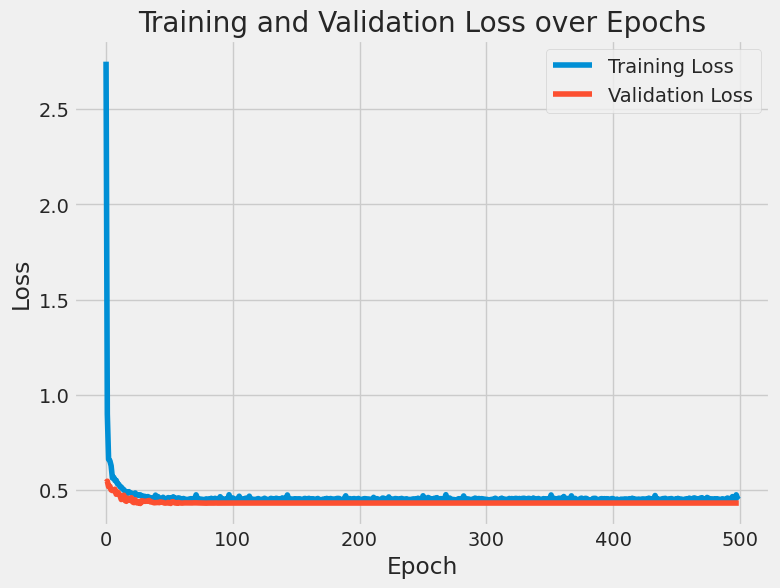

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_values, label="Training Loss")
plt.plot(valid_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

#### ROC Curve

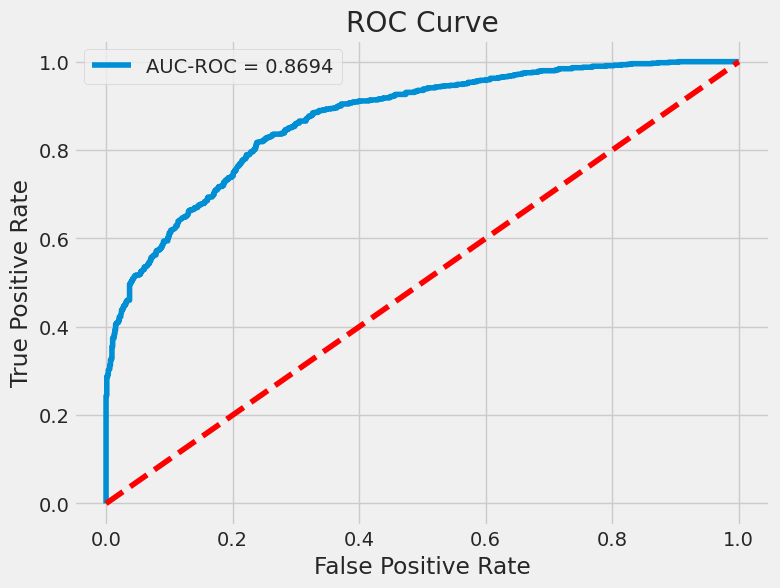

In [47]:
fpr, tpr, _ = roc_curve(y_test, test_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {test_auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="r")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

#### Confusion Matrix

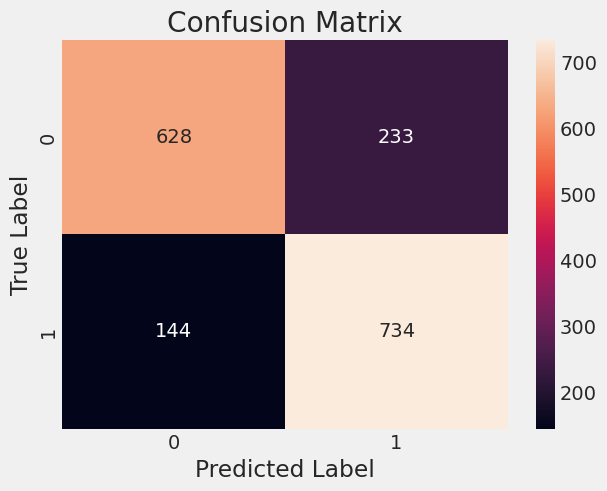

In [48]:
cm = confusion_matrix(y_test.numpy(), test_predictions.round())
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Submission

In [49]:
test_competition = torch.tensor(np.array(test), dtype=torch.float32).to(device)

model.eval()
test_competition_predictions = []
with torch.no_grad():
    outputs = model(test_competition)
    test_competition_predictions.extend(outputs.cpu().numpy())

test_competition_predictions = np.array(test_competition_predictions).flatten()

submission = pd.DataFrame({
    'Id': test_IDs,
    'Label': test_competition_predictions
})

submission.to_csv('submission.csv', index=False)